# Imports

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
import scanpy as sc
import pyranges as pr
import warnings

In [3]:
import palantir 
import phenograph
import harmony

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [4]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
matplotlib.rcParams["font.family"] = "Helvetica"

In [6]:
%env R_HOME=/usr/lib64/R

env: R_HOME=/usr/lib64/R


In [7]:
plot_prefix = 'plots/Fig4_'

# Utility functions

In [8]:
def log_transform(ad, ps=0.1):
    ad.X.data = np.log2(ad.X.data + ps) - np.log2(ps)

In [9]:
from joblib import Parallel, delayed
from scipy.sparse import hstack, csr_matrix, issparse
import gc


def _dot_func(x, y):
    return x.dot(y)


def impute_data(dm_res, ad, n_steps=3):
    T_steps = dm_res['T'] ** n_steps
    T_steps = T_steps.astype(np.float32)

    # RUn in parallel
    seq = np.append(np.arange(0, ad.X.shape[1], 100), [ad.X.shape[1]])
    res = Parallel(n_jobs=-1)(delayed(_dot_func)(T_steps, ad.X[:, seq[i - 1]:seq[i]]) for i in range(1, len(seq)))
    imputed_data = hstack(res)
    imputed_data = imputed_data.todense()
    imputed_data[imputed_data < 1e-2] = 0
    gc.collect()

    return imputed_data

In [10]:
def pyranges_from_strings(pos_list):
    # Chromosome and positions
    chr = pos_list.str.split(':').str.get(0)
    start = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(0)
    end = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(1)
    
    # Create ranges
    gr = pr.PyRanges(chromosomes=chr, starts=start, ends=end)
    
    return gr


def pyranges_to_strings(peaks):
    # Chromosome and positions
    chr = peaks.Chromosome.astype(str).values
    start = peaks.Start.astype(str).values
    end = peaks.End.astype(str).values
    
    # Create ranges
    gr = chr + ':' + start + '-' + end
    
    return gr

In [11]:
def plot_gene_expression(
    data,
    tsne,
    genes,
    plot_scale=False,
    n_cols=5,
    percentile=0,
    s=3,
    cmap=matplotlib.cm.Spectral_r,
):
    """ Plot gene expression on tSNE maps
    :param genes: Iterable of strings to plot on tSNE
    """

    not_in_dataframe = set(genes).difference(data.columns)
    if not_in_dataframe:
        if len(not_in_dataframe) < len(genes):
            print(
                "The following genes were either not observed in the experiment, "
                "or the wrong gene symbol was used: {!r}".format(not_in_dataframe)
            )
        else:
            print(
                "None of the listed genes were observed in the experiment, or the "
                "wrong symbols were used."
            )
            return

    # remove genes missing from experiment
    genes = pd.Series(genes)[pd.Series(genes).isin(data.columns)]

    # Plot
    cells = data.index.intersection(tsne.index)
    fig = palantir.plot.FigureGrid(len(genes), n_cols)

    for g, ax in zip(genes, fig):
        # Data
        c = data.loc[cells, g]
        vmin = np.percentile(c[~np.isnan(c)], percentile)
        vmax = np.percentile(c[~np.isnan(c)], 100 - percentile)

        ax.scatter(
            tsne.loc[cells, "x"],
            tsne.loc[cells, "y"],
            s=s,
            c=c,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
        )
        ax.set_axis_off()
        ax.set_title(g)

        if plot_scale:
            normalize = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
            cax, _ = matplotlib.colorbar.make_axes(ax)
            matplotlib.colorbar.ColorbarBase(cax, norm=normalize, cmap=cmap)



In [12]:

def plot_gene_trends(gene_trends, genes=None, colors=None, plot_std=True):
    """ Plot the gene trends: each gene is plotted in a different panel
    :param: gene_trends: Results of the compute_marker_trends function
    """

    # Branches and genes
    branches = list(gene_trends.keys())
    if colors is None:
        colors = pd.Series(
            sns.color_palette("Set2", len(branches)).as_hex(), index=branches
        )
    if genes is None:
        genes = gene_trends[branches[0]]["trends"].index

    # Set up figure
    fig = plt.figure(figsize=[7, 3 * len(genes)])
    for i, gene in enumerate(genes):
        ax = fig.add_subplot(len(genes), 1, i + 1)
        for branch in branches:
            trends = gene_trends[branch]["trends"]
            stds = gene_trends[branch]["std"]
            ax.plot(
                trends.columns, trends.loc[gene, :], color=colors[branch], label=branch
            )
            ax.set_xticks([0, 1])
            if plot_std:
                ax.fill_between(
                    trends.columns,
                    trends.loc[gene, :] - stds.loc[gene, :],
                    trends.loc[gene, :] + stds.loc[gene, :],
                    alpha=0.1,
                    color=colors[branch],
                )
            ax.set_title(gene)
        # Add legend
        if i == 0:
            ax.legend()

    sns.despine()


In [13]:
def _gam_fit_predict(x, y, weights=None, pred_x=None):

    import rpy2.robjects as robjects
    from rpy2.robjects import pandas2ri, Formula
    from rpy2.robjects.packages import importr

    pandas2ri.activate()

    # Weights
    if weights is None:
        weights = np.repeat(1.0, len(x))

#     gam = LinearGAM(s(0)).fit(x, y)    
#     y_pred = gam.predict(pred_x)
#     return y_pred, 0
    
    # Construct dataframe
    use_inds = np.where(weights > 0)[0]
    r_df = pandas2ri.py2rpy(
        pd.DataFrame(np.array([x, y]).T[use_inds, :], columns=["x", "y"])
    )

    # Fit the model
    rgam = importr("gam")
    model = rgam.gam(Formula("y~s(x, 3)"), data=r_df, weights=pd.Series(weights[use_inds]))

    # Predictions
    if pred_x is None:
        pred_x = x
    y_pred = np.array(
        robjects.r.predict(
            model, newdata=pandas2ri.py2rpy(pd.DataFrame(pred_x, columns=["x"]))
        )
    )

    # Standard deviations
    p = np.array(
        robjects.r.predict(
            model, newdata=pandas2ri.py2rpy(pd.DataFrame(x[use_inds], columns=["x"]))
        )
    )
    n = len(use_inds)
    sigma = np.sqrt(((y[use_inds] - p) ** 2).sum() / (n - 2))
    stds = (
        np.sqrt(1 + 1 / n + (pred_x - np.mean(x)) ** 2 / ((x - np.mean(x)) ** 2).sum())
        * sigma
        / 2
    )

    return y_pred, stds


# Load data

In [14]:
data_dir = os.path.expanduser('/home/ec2-user/projects/metacells/data/CD34/Multiome/')

In [15]:
rna_ad = sc.read(data_dir + 'cd34_multiome_rna_no_bcells.h5ad')
atac_ad = sc.read(data_dir + 'cd34_multiome_atac_no_bcells.h5ad')
atac_archr_vanilla = sc.read(data_dir + 'cd34_multiome_atac_no_bcells_archr_vanilla.h5ad')

In [16]:
rna_ad

AnnData object with n_obs × n_vars = 6881 × 12464
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'Metacell', 'palantir_pseudotime', 'palantir_diff_potential', 'Metacell_Entropy'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'DMEigenValues', 'celltype_colors', 'ct_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'palantir_branch_probs_columns', 'pca', 'phenograph_colors', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'X_FDL', 'X_pca', 'X_umap', 'palantir_branch_probs'
    varm: 'PCs'
    layers: 'MAGIC_imputed_data'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

In [17]:
# Diffusion maps object
dm_res = dict()
dm_res['EigenVectors'] = pd.DataFrame(rna_ad.obsm['DM_EigenVectors'], 
                                     index=rna_ad.obs_names)
dm_res['EigenValues'] = rna_ad.uns['DMEigenValues']
dm_res['kernel'] = rna_ad.obsp['DM_Kernel']

In [18]:
# Diffusion maps object
atac_dm_res = dict()
atac_dm_res['EigenVectors'] = pd.DataFrame(atac_ad.obsm['DM_EigenVectors'], 
                                     index=atac_ad.obs_names)
atac_dm_res['EigenValues'] = atac_ad.uns['DM_EigenValues']
atac_dm_res['kernel'] = atac_ad.obsp['DM_kernel']

In [19]:
ct_colors = pd.Series(rna_ad.uns['celltype_colors'], 
                     index=rna_ad.obs['celltype'].values.categories)

## ATAC TF-IDF

In [20]:
from sklearn.feature_extraction.text import TfidfTransformer

In [21]:
tfidf = TfidfTransformer()
tfidf.fit(atac_ad.X)
atac_ad.layers['TFIDF'] = tfidf.transform(atac_ad.X)

In [22]:
tfidf = TfidfTransformer()
tfidf.fit(atac_archr_vanilla.X)
atac_archr_vanilla.layers['TFIDF'] = tfidf.transform(atac_archr_vanilla.X)

## ATAC Meta cell 

In [23]:
from tqdm.notebook import tqdm

In [24]:
# Summary matrix
metacells = atac_ad.obs['Metacell'].astype(str).unique()
summ_matrix = pd.DataFrame(0.0, index=metacells, columns=atac_ad.var_names)

for m in summ_matrix.index:
    cells = atac_ad.obs_names[atac_ad.obs['Metacell'] == m]
    summ_matrix.loc[m, :] = np.ravel(atac_ad[cells, :].X.sum(axis=0))

In [25]:
# Ann data
# Counts
atac_meta_ad = sc.AnnData(summ_matrix)
atac_meta_ad.X = csr_matrix(atac_meta_ad.X)
atac_meta_ad.obs_names, atac_meta_ad.var_names = summ_matrix.index.astype(str), atac_ad.var_names

In [26]:
atac_meta_ad.raw = sc.AnnData(atac_meta_ad.X)

In [27]:
sc.pp.normalize_per_cell(atac_meta_ad)

In [28]:
atac_ad.obs['RNAMetacell'] = rna_ad.obs['Metacell']

## RNA meta cell

In [29]:
# Summary matrix
metacells = atac_ad.obs['Metacell'].astype(str).unique()
summ_matrix = pd.DataFrame(0.0, index=metacells, columns=rna_ad.var_names)

for m in tqdm(summ_matrix.index):
    cells = rna_ad.obs_names[atac_ad.obs['Metacell'] == m]
    summ_matrix.loc[m, :] = np.ravel(rna_ad[cells, :].X.sum(axis=0))

In [30]:
# Ann data
# Counts
rna_meta_ad = sc.AnnData(summ_matrix)
rna_meta_ad.X = csr_matrix(rna_meta_ad.X)
rna_meta_ad.obs_names, rna_meta_ad.var_names = summ_matrix.index.astype(str), rna_meta_ad.var_names

In [31]:
rna_meta_ad.raw = sc.AnnData(rna_meta_ad.X)

In [32]:
sc.pp.normalize_per_cell(rna_meta_ad)

In [33]:
rna_meta_ad.obs['palantir_pseudotime'] = rna_ad.obs['palantir_pseudotime'].groupby(atac_ad.obs['Metacell']).mean()[rna_meta_ad.obs_names]

In [34]:
atac_meta_ad

AnnData object with n_obs × n_vars = 100 × 246113
    obs: 'n_counts'

In [35]:
rna_meta_ad

AnnData object with n_obs × n_vars = 100 × 12464
    obs: 'n_counts', 'palantir_pseudotime'

## TFs

In [36]:
human_tfs = pd.read_csv('/home/ec2-user/data/AnimalTFDB/Homo_sapiens.txt', sep='\t')['Symbol'].unique()

## Erythroid cells

In [37]:
ct_sc_cells = rna_ad.obs_names[rna_ad.obs['celltype'].isin(['HSC', 'MEP', 'Ery'])]

# Expression -vs- accessibility

## Load results

In [38]:
dorc_dir = os.path.expanduser('~/projects/metacells/data/CD34/Multiome/outs/')

In [39]:
gene_res = pd.read_pickle(dorc_dir + 'cd34_meta_dorc_correlations.p')
gene_scores = pd.read_pickle(dorc_dir + 'cd34_meta_dorc_gene_scores.p')

In [40]:
sc_gene_res = pd.read_pickle(dorc_dir + 'cd34_sc_correlations.p')
sc_gene_scores = pd.read_pickle(dorc_dir + 'cd34_sc_gene_scores.p')

In [41]:
sc_gs_ad = sc.read(dorc_dir + 'cd34_sc_gs.h5ad')
meta_gs_ad = sc.read(dorc_dir + 'cd34_meta_gs.h5ad')

In [45]:
!cp /home/ec2-user/projects/metacells/data/CD34/Multiome/outs/cd34_meta_dorc_gene_scores.p res/

# Coverage related

## Coverage plot functions

In [56]:
import tabix
import subprocess

import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle, Arc
from matplotlib.collections import PatchCollection

In [57]:
def compute_coverage(fragments_files, region, barcodes, out_prefix, 
                     smooth=None, normalize=False, frag_type='All'):

    # Bed file
    bed_file = open(out_prefix + '.bed', 'w')

    for sample in fragments_files.keys():
        tb = tabix.open(fragments_files[sample])
        records = tb.querys(region)
    
        # Iterate and write bed file
        for record in records:
            if record[3] in barcodes[sample]:
                # Write to bed file if the read is NFR
                if frag_type == 'NFR' and int(record[2]) - int(record[1]) > 145:
                    continue 
                if frag_type == 'NUC' and int(record[2]) - int(record[1]) <= 145:
                    continue 

                # Write to bed file
                line = record[0] + '\t' + record[1] + '\t' + record[2] + '\n'
                bed_file.writelines(line)

    # Close bed file
    bed_file.close()

    # Region to bed
    line = region.replace(':', '\t').replace('-', '\t') + '\n'
    bed_file = open(out_prefix + '.region.bed', 'w')
    bed_file.writelines(line)
    bed_file.close()

    # Coverage
    out_file = open(out_prefix + '.coverage.bed', 'w')
    args = ['bedtools', 'coverage', '-a', out_prefix + '.region.bed', '-b',
            out_prefix + '.bed', '-d']
    subprocess.call(args, stdout=out_file)
    out_file.close()

    # Read coverage
    df = pd.read_csv(out_prefix + '.coverage.bed', sep='\t', header=None)
    coverage = pd.Series(df[4].values, index=df[1] + df[3] - 1)
    coverage.attrs['chr'] = df[0][0]

    # Smooth if specified
    if smooth:
        coverage = coverage.rolling(smooth).mean()
        coverage[coverage.isnull()] = coverage.iloc[smooth]

    if normalize:
        nFrags = 0
        for sample in barcodes.index:
            sample_bc = (atac_ad.obs_names.str.contains(sample)) & (atac_ad.obs['FragSample'].isin(barcodes[sample]))
            nFrags += atac_ad.obs['nFrags'][sample_bc].sum()
        norm = 1e6 / nFrags
        coverage = coverage * norm

    # Clean up
    os.unlink(out_prefix + '.bed')
    os.unlink(out_prefix + '.coverage.bed')
    os.unlink(out_prefix + '.region.bed')

    return coverage

In [58]:
# Plot coverage
def _plot_coverage(coverage, track_name='Coverage', ax=None, color='#ff7f00',
                   min_coverage=0, ylim=None, fill=True, linestyle='-', y_font=None):
    if ax is None:
        plt.figure()
        ax = plt.gca()

    if y_font is not None:
        ax.tick_params(axis='y', labelsize=y_font)


    # Plot and fill
    values = coverage
    values[values <= min_coverage] = 0
    if fill:
        ax.plot(coverage.index, values, color='black', linewidth=0.5)
        ax.fill_between(coverage.index, 0, values, color=color)
#         ax.set_ylabel(track_name)
    else:
        ax.plot(coverage.index, values, color=color, 
                linestyle=linestyle, linewidth=0.75)

    # Scale
    if ylim is not None:
        ax.set_ylim(ylim)
    sns.despine(ax=ax)

    
# BED plot
def _plot_bed(plot_peaks, track_name="Bed", ax=None, facecolor='#ff7f00'):

    if ax is None:
        plt.figure()
        ax = plt.gca()
    
    rects = []
    if len(plot_peaks) > 0:
        for s, e in zip(plot_peaks.Start, plot_peaks.End):
            rects.append(Rectangle((s, -0.45), e - s, 0.9))

    # Add rectangles
    # Dummy scatter
    pc = PatchCollection(rects, facecolor=facecolor, edgecolor='black')
    ax.add_collection(pc)

    # Axis annotation
    ax.set_ylim([-1, 1])
    sns.despine(ax=ax, bottom=True)
    ax.set_yticks([])
#     ax.set_ylabel(track_name, rotation=0)
    ax.axes.get_xaxis().set_visible(False)


# Gene plot
def _plot_gene(genes, ax=None, track_name='Genes', facecolor='#377eb8',
               exon_height=0.9, utr_height=0.4):
    # Setup plot
    if ax is None:
        plt.figure()
        ax = plt.gca()

    for gene in np.unique(genes.gene_name):
        gene_pr = genes[genes.gene_name == gene]

        # Plot lines
        gs, ge = gene_pr[gene_pr.Feature == 'gene'].Start.values[0], gene_pr[gene_pr.Feature == 'gene'].End.values[0]
        ax.plot([gs, ge], [0, 0], color='black')
        ax.set_ylim([-1, 1])
#         ax.text((gs + ge) / 2,
#                 -(exon_height + utr_height), gene, horizontalalignment='center')

        # UTRs
        utrs = gene_pr[gene_pr.Feature.astype(str).str.contains('utr')]
        if len(utrs) > 0:
            rects = []
            for s, e in zip(utrs.Start, utrs.End):
                rects.append(Rectangle((s, -utr_height / 2), e - s, utr_height))
            ax.add_collection(PatchCollection(rects, facecolor=facecolor, edgecolor='black'))

        # CDS
        cds = gene_pr[gene_pr.Feature.astype(str).str.contains('CDS')]
        if len(cds) == 0:
            cds = gene_pr[gene_pr.Feature.astype(str).str.contains('exon')]
        rects = []
        for s, e in zip(cds.Start, cds.End):
            rects.append(Rectangle((s, -exon_height / 2), e - s, exon_height))
        ax.add_collection(PatchCollection(rects, facecolor=facecolor, edgecolor='black'))

        # Arrow indicating direction
#         rs, re = ax.get_xlim()
#         if gene_pr.stranded:
#             s, e = cds.Start.values[0], cds.End.values[0]
#             if gene_pr.Strand.values[0] == '+':
#                 ax.plot([s, e], np.repeat(-0.65, 2), color='red', linewidth=1, alpha=1)
#                 ax.plot([e - (re - rs) / 100, e], [-0.95, -0.65], color='red', linewidth=1, alpha=1)
#                 ax.plot([e - (re - rs) / 100, e], [-0.35, -0.65], color='red', linewidth=1, alpha=1)
#             else:
#                 ax.plot([s, e], np.repeat(-0.65, 2), color='red', linewidth=1, alpha=1)
#                 ax.plot([s + (re - rs) / 100, s], [-0.95, -0.65], color='red', linewidth=1, alpha=1)
#                 ax.plot([s + (re - rs) / 100, s], [-0.35, -0.65], color='red', linewidth=1, alpha=1)

    # Axis clean up
#     ax.set_ylabel(track_name)
    sns.despine(ax=ax)
    ax.set_yticks([])
    
    
# Links plot
def _plot_links(links, ax):
    for start, end, cor in zip(links['start'], links['end'], links['cor']):
        center = (start + end) / 2
        width = np.abs(center - start) * 2

        a = Arc((center, 0), width,  width, 
                0, 180, 360, lw=1.25,
                color=sns.dark_palette("Blues", reverse=True, as_cmap=True)(cor))
        ax.add_patch(a)

    ax.set_ylim([np.min(-np.abs((links['end'] + start)/2 - start)) - 100, 0])
    ax.set_axis_off()

In [59]:
def plot_coverage(barcode_groups, region, fragments_files,
                  peak_groups=None, genes=None, highlight_peaks=None,
                  min_coverage=0, smooth=None, common_scale=False,
                  plot_cov_size=2, plot_bed_size=0.75, collapsed=False,
                  coverage_colors=None, fig_width=15, frag_type='All', 
                  normalize=True, links=None, y_font=None):

    # Determine coverages
    coverages = dict()
    for k in barcode_groups.index:
        iter_norm = normalize
        if k == 'Single-cell':
            iter_norm = False
        coverages[k] = compute_coverage(fragments_files, region, barcode_groups[k],
                                        '/tmp/test', smooth, iter_norm, frag_type)
    # Plot
    n_rows = len(coverages)
    size = plot_cov_size * n_rows
    ratios = np.repeat(1, n_rows)
    if collapsed:
        n_rows = 1
        size = plot_cov_size * 4
        ratios = np.repeat(4, 1)
    if peak_groups is not None:
        size += plot_bed_size * len(peak_groups)
        n_rows += len(peak_groups)
        ratios = np.append(ratios, np.repeat(plot_bed_size / plot_cov_size, len(peak_groups)))
    if links is not None:
        link_frac = 0.75
        size += plot_cov_size * link_frac
        n_rows += 1
        ratios = np.append(ratios, link_frac)
    if genes is not None:
        size += plot_bed_size
        n_rows += 1
        ratios = np.append(ratios, plot_bed_size / plot_cov_size)

    # Colors
    if coverage_colors is None:
        coverage_colors = pd.Series(sns.color_palette('Set2', len(coverages)).as_hex(),
                                    index=barcode_groups.index)

    # Y min and max
    ylim = None
    if common_scale:
        ymin = np.inf
        ymax = -np.inf
        for row in barcode_groups.index:
            if row == 'Single-cell':
                continue
            ymin = np.min([ymin, np.min(coverages[row])])
            ymax = np.max([ymax, np.max(coverages[row])])
        ylim = [ymin, ymax]


    # Region pyranges
    pr_region = pr.from_dict({'Chromosome': [region.split(':')[0]],
                              'Start': [int(region.split(':')[1].split('-')[0])],
                              'End': [int(region.split('-')[1])]})
    if highlight_peaks is not None:
        highlight_peaks = highlight_peaks.overlap(pr_region)
        
    # Plot
    fig = plt.figure(figsize=[fig_width, size])
    gs = gridspec.GridSpec(n_rows, 1, height_ratios=ratios, figure=fig)

    # Coverages
    plot_index = 0
    if collapsed:
        ax = fig.add_subplot(gs[plot_index, 0])
        ax.set_xlim([pr_region.Start[0], pr_region.End[0]])
        plot_index += 1

    for row in barcode_groups.index:
        # Create subplot
        if not collapsed:
            ax = fig.add_subplot(gs[plot_index, 0])
            ax.set_xlim([pr_region.Start[0], pr_region.End[0]])
            plot_index += 1

        iter_ylim = ylim
        if row == 'Single-cell':
            iter_ylim = [0, 2]
        _plot_coverage(coverages[row], row, ax, coverage_colors[row],
                       min_coverage, iter_ylim, not collapsed, y_font=y_font)

        # Highlight peaks
        if highlight_peaks is not None:
            for s, e in zip(highlight_peaks.Start, highlight_peaks.End):
                rect = Rectangle((s, 0), e - s, ax.get_ylim()[1],
                                 color='black', alpha=0.07, zorder=1000)
                ax.add_patch(rect)

        # Reset axis
        if plot_index != n_rows:
            ax.set_xticks([])


    # Region pyranges
    pr_region = pr.from_dict({'Chromosome': [region.split(':')[0]],
                              'Start': [int(region.split(':')[1].split('-')[0])],
                              'End': [int(region.split('-')[1])]})

    # Peaks
    if peak_groups is not None:
        for row in peak_groups.index:
            plot_peaks = peak_groups[row].overlap(pr_region)

            ax = fig.add_subplot(gs[plot_index, 0])
            ax.set_xlim([pr_region.Start[0], pr_region.End[0]])
            plot_index += 1

            _plot_bed(plot_peaks, row, ax, facecolor=coverage_colors[row])
    
    
    # Links
    if links is not None:
        ax = fig.add_subplot(gs[plot_index, 0])
        ax.set_xlim([pr_region.Start[0], pr_region.End[0]])
        plot_index += 1

        _plot_links(links, ax)

    # Genes
    if genes is not None:
        genes = genes.overlap(pr_region)
        genes.End[genes.End > pr_region.End[0]] = pr_region.End[0]
        genes.Start[genes.Start < pr_region.Start[0]] = pr_region.Start[0]


        # Setup plot
        ax = fig.add_subplot(gs[plot_index, 0])
        ax.set_xlim([pr_region.Start[0], pr_region.End[0]])
        plot_index += 1

        _plot_gene(genes, ax, track_name='Genes')

        # Axis clean up
#         ax.set_ylabel('Genes', rotation=0)
        sns.despine(ax=ax)
        ax.set_yticks([])



    # Clean up axis annotation
    ax.axes.get_xaxis().set_visible(True)
    locs = ax.get_xticks()[[0, -1]]
#     locs[0] += 10000
#     locs[1] -= 10000
    ax.set_xticks(locs)
    ax.set_xticklabels([str(int(t)) for t in ax.get_xticks()])
    ax.set_xlabel(region.split(':')[0])



In [60]:
sns.dark_palette("#69d", reverse=True, as_cmap=True)

## GTF

In [61]:
gtf = pr.read_gtf(os.path.expanduser('~/data/genomes/hg38.gtf'))
gtf.Chromosome = 'chr' + gtf.Chromosome.astype(str)

## Fragment files

In [62]:
frag_dir = os.path.expanduser('~/projects/metacells/data/CD34/Multiome/')

fragment_files = dict()
fragment_files['cd34_multiome_rep1'] = frag_dir + 'rep1/atac_fragments.tsv.gz'
fragment_files['cd34_multiome_rep2'] = frag_dir + 'rep2/atac_fragments.tsv.gz'

## Chromsizes

In [63]:
chromsizes = os.path.expanduser('~/projects/metacells/data/CD34/ATAC/chromsizes')

## Peaks

In [64]:
peak_groups = pd.Series()
peak_groups['Peaks'] = pyranges_from_strings(atac_ad.var_names)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [65]:
atac_ad.obs['FragSample'] = atac_ad.obs_names.str.split('#').str.get(1).astype(str)

# Gene - peak associations

In [66]:
# ct_order = ['HSC', 'HMP', 'MEP', 'Ery', 'CLP', 'Mono', 'cDC', 'pDC']
ct_order = ['HSC', 'MEP', 'Ery']

In [67]:
barcode_groups = pd.Series([], dtype=object)
for test_ct in ct_order:
    # Cell type cells
    cells = rna_ad.obs_names[rna_ad.obs['celltype'] == test_ct]
    barcode_groups[test_ct] = pd.Series([], dtype=object)
    for r in ['cd34_multiome_rep1', 'cd34_multiome_rep2']:
        barcode_groups[test_ct][r] = atac_ad.obs['FragSample'][cells][cells.str.contains(r)].values
    
peak_groups = pd.Series()
peak_groups['Peaks'] = pyranges_from_strings(atac_ad.var_names)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if __name__ == '__main__':


In [68]:
cluster_colors = ct_colors.copy()
cluster_colors['Peaks'] = '#FDB396'

In [69]:
pval_cutoff = 1e-1
cor_cutoff = 0.2

anchor_gene = 'KLF1'
meta_peaks = gene_res[anchor_gene].index[gene_res[anchor_gene]['pval'] < pval_cutoff].sort_values()
meta_peaks = meta_peaks[gene_res[anchor_gene].loc[meta_peaks, 'cor'] > cor_cutoff]
# meta_peaks = meta_peaks[1:]

In [70]:
# region = meta_peaks[0].split('-')[0] + '-' + meta_peaks[-1].split('-')[1]

# region = 'chr1:47177959-47244603'
region = 'chr19:12,878,743-12,892,451'.replace(',', '')

pr_region = pr.from_dict({'Chromosome': [region.split(':')[0]],
                              'Start': [int(region.split(':')[1].split('-')[0])],
                              'End': [int(region.split('-')[1])]})

genes = gtf.intersect(pr_region)
genes = genes[genes.gene_name.isin([anchor_gene])]

In [71]:
cors = gene_res[anchor_gene].loc[meta_peaks, 'cor']

# Gene start
sub_gtf = genes[genes.gene_name == anchor_gene]
gene_start = sub_gtf.Start.iloc[0]  if sub_gtf.Strand.iloc[0] == '+' else sub_gtf.End.iloc[0]

# Peak centers
meta_pr = pyranges_from_strings(meta_peaks)
meta_pr = meta_pr.overlap(pr_region)
ends = (meta_pr.End + meta_pr.Start) / 2

links = pd.DataFrame([np.repeat(gene_start, len(ends)), ends.values, cors[pyranges_to_strings(meta_pr)].values]).T
links.columns = ['start', 'end', 'cor']

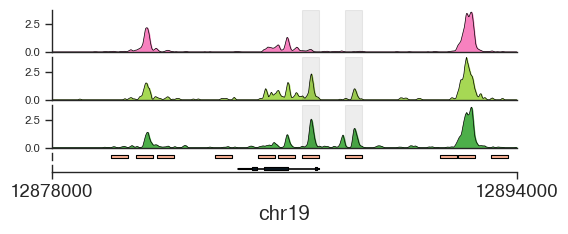

In [72]:
plot_coverage(barcode_groups, region, fragment_files, 
              peak_groups, genes=genes, highlight_peaks=meta_pr,
              common_scale=True, smooth=75, 
              fig_width=6,  plot_cov_size = 0.65, plot_bed_size=0.1,
              frag_type='NFR', normalize=True, 
             coverage_colors=cluster_colors, min_coverage=0.01, links=None, y_font=8)
plt.savefig(plot_prefix + f'{anchor_gene}_dorc_coverage.png', dpi=150)

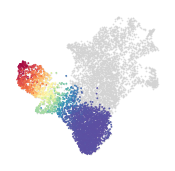

In [59]:
plt.figure(figsize=[2, 2])

umap = rna_ad.obsm['X_umap']
plt.scatter(umap[:, 0], umap[:, 1], 
            s=0.1, color='lightgrey')

umap = rna_ad[ct_sc_cells].obsm['X_umap']
plt.scatter(umap[:, 0], umap[:, 1], 
           s=0.25, c=np.ravel(rna_ad[ct_sc_cells, ][:, anchor_gene].layers['MAGIC_imputed_data']))
ax = plt.gca()
ax.set_axis_off()
plt.savefig(plot_prefix + f'{anchor_gene}_expression.png', dpi=150)

In [60]:
pval_cutoff = 1e-1
cor_cutoff = 0.2

anchor_gene = 'LPCAT2'
region = 'chr16:55,474,586-55,531,723'.replace(',', '')

# anchor_gene = 'TCF4'
# region = 'chr18:55,220,185-55,590,192'.replace(',', '')


pr_region = pr.from_dict({'Chromosome': [region.split(':')[0]],
                              'Start': [int(region.split(':')[1].split('-')[0])],
                              'End': [int(region.split('-')[1])]})

meta_peaks = gene_res[anchor_gene].index[gene_res[anchor_gene]['pval'] < pval_cutoff].sort_values()
meta_peaks = meta_peaks[gene_res[anchor_gene].loc[meta_peaks, 'cor'] > cor_cutoff]


genes = gtf.intersect(pr_region)
genes = genes[genes.gene_name.isin([anchor_gene])]


cors = gene_res[anchor_gene].loc[meta_peaks, 'cor']

# Gene start
sub_gtf = genes[genes.gene_name == anchor_gene]
gene_start = sub_gtf.Start.iloc[0]  if sub_gtf.Strand.iloc[0] == '+' else sub_gtf.End.iloc[0]

# Peak centers
meta_pr = pyranges_from_strings(meta_peaks)
meta_pr = meta_pr.overlap(pr_region)
ends = (meta_pr.End + meta_pr.Start) / 2

# links = pd.DataFrame([np.repeat(gene_start, len(ends)), ends.values, cors[pyranges_to_strings(meta_pr)].values]).T
# links.columns = ['start', 'end', 'cor']

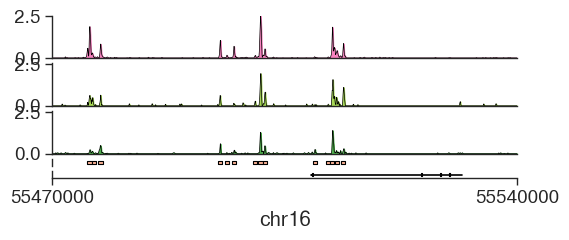

In [61]:
plot_coverage(barcode_groups, region, fragment_files, 
              peak_groups, genes=genes, highlight_peaks=None,
              common_scale=True, smooth=75, 
              fig_width=6,  plot_cov_size = 0.65, plot_bed_size=0.1,
              frag_type='NFR', normalize=True, 
             coverage_colors=cluster_colors, min_coverage=0.01, links=None, y_font=8)
plt.savefig(plot_prefix + f'{anchor_gene}_dorc_coverage.png', dpi=150)

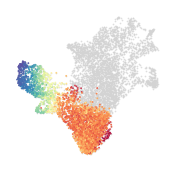

In [62]:
plt.figure(figsize=[2, 2])

umap = rna_ad.obsm['X_umap']
plt.scatter(umap[:, 0], umap[:, 1], 
            s=0.1, color='lightgrey')

umap = rna_ad[ct_sc_cells].obsm['X_umap']
plt.scatter(umap[:, 0], umap[:, 1], 
           s=0.25, c=np.ravel(rna_ad[ct_sc_cells, ][:, anchor_gene].layers['MAGIC_imputed_data']))
ax = plt.gca()
ax.set_axis_off()
plt.savefig(plot_prefix + f'{anchor_gene}_expression.png', dpi=150)

# DORC associations

## Load results

In [123]:
import pickle

In [124]:
out_dir = '/home/ec2-user/projects/metacells/data/CD34/Multiome/outs/dorc_associations/'

In [125]:
with open(out_dir + 'cd34_metacell_open_peaks.p', 'rb') as f:
    meta_open_peaks, meta_dorc_peaks = pickle.load(f)
    
with open(out_dir + 'cd34_celltype_open_peaks.p', 'rb') as f:
    ct_open_peaks, ct_dorc_peaks = pickle.load(f)
    
with open(out_dir + 'cd34_metacell_dorc_ery_trends.p', 'rb') as f:
    ery_trend_df, lin_high_genes, lin_low_genes = pickle.load(f)
    
with open(out_dir + 'cd34_metacell_rna_meta_pr_res.p', 'rb') as f:
    rna_meta_pr_res = pickle.load(f)

In [126]:
with open(out_dir + 'cd34_singlecell_open_peaks.p', 'rb') as f:
    sc_dorc_peaks = pickle.load(f)


In [127]:
dorc_cors = pd.read_pickle('/home/ec2-user/projects/metacells/data/CD34/Multiome/outs/cd34_meta_dorc_correlations.p')

## Cell type results summary

In [72]:
ct_colors['Baso'] = '#b2df8a'

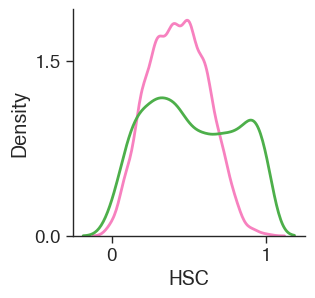

In [73]:
# Behavior of peaks open in HSCs
plt.figure(figsize=[3, 3])
for ct in ['HSC', 'Ery']:
    sns.kdeplot(ct_dorc_peaks[ct], color=ct_colors[ct], linewidth=2, legend=None)
# for ct in ['Mono', 'Baso']:
#     sns.kdeplot(bmmc_dorc_peaks[ct], color=ct_colors[ct], linewidth=2, legend=None)
sns.despine()
# plt.legend(loc=2, bbox_to_anchor=(1, 1))
plt.xticks([0.0, 1.0])
plt.yticks([0.0, 1.5])

# plt.xlabel('Fraction of accessible DORC peaks ')
# plt.ylabel('Density')
plt.savefig(plot_prefix + f'cell_type_dorc_fractions.png', dpi=150)

In [155]:
ct_colors['Mega'] = ct_colors['MEP']

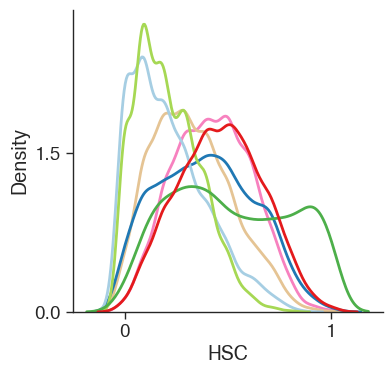

In [156]:
# Behavior of peaks open in HSCs
plt.figure()
for ct in [ 'HSC','CLP', 'cDC', 'pDC', 'Mega', 'Ery', 'Mono']:
    sns.kdeplot(ct_dorc_peaks[ct], color=ct_colors[ct], linewidth=2, legend=None)
sns.despine()
# plt.legend(loc=2, bbox_to_anchor=(1, 1))
plt.xticks([0.0, 1.0])
plt.yticks([0.0, 1.5])
plt.savefig(plot_prefix + f'cell_type_dorc_fractions_all_ct.png', dpi=150)

# plt.xlabel('Fraction of accessible DORC peaks ')
# plt.ylabel('Density')

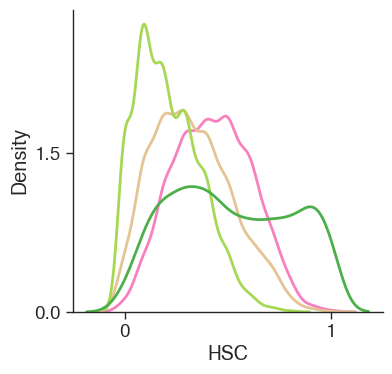

In [157]:
# Behavior of peaks open in HSCs
plt.figure()
for ct in [ 'HSC','CLP', 'Mega', 'Ery']:
    sns.kdeplot(ct_dorc_peaks[ct], color=ct_colors[ct], linewidth=2, legend=None)
sns.despine()
# plt.legend(loc=2, bbox_to_anchor=(1, 1))
plt.xticks([0.0, 1.0])
plt.yticks([0.0, 1.5])
plt.savefig(plot_prefix + f'cell_type_dorc_fractions_set1_ct.png', dpi=150)

# plt.xlabel('Fraction of accessible DORC peaks ')
# plt.ylabel('Density')

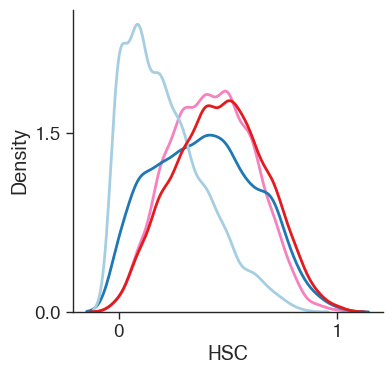

In [158]:
# Behavior of peaks open in HSCs
plt.figure()
for ct in [ 'HSC','cDC', 'pDC', 'Mono']:
    sns.kdeplot(ct_dorc_peaks[ct], color=ct_colors[ct], linewidth=2, legend=None)
sns.despine()
# plt.legend(loc=2, bbox_to_anchor=(1, 1))
plt.xticks([0.0, 1.0])
plt.yticks([0.0, 1.5])
plt.savefig(plot_prefix + f'cell_type_dorc_fractions_set2_ct.png', dpi=150)

# plt.xlabel('Fraction of accessible DORC peaks ')
# plt.ylabel('Density')

## Meta cell results

In [76]:
ct_meta_cells = meta_dorc_peaks.columns[rna_ad.obs['celltype'][meta_dorc_peaks.columns].isin(['HSC', 'MEP', 'Ery'])]

In [82]:
rna_meta_ad.obsm['X_umap'] = rna_ad[rna_meta_ad.obs_names, :].obsm['X_umap']

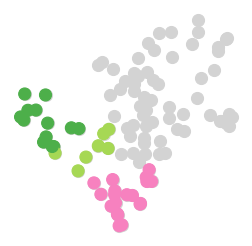

In [83]:
plt.figure(figsize=[3, 3])
plt.scatter(rna_meta_ad.obsm['X_umap'][:, 0], 
           rna_meta_ad.obsm['X_umap'][:, 1], s=75, color='lightgrey')
plt.scatter(rna_meta_ad[ct_meta_cells].obsm['X_umap'][:, 0], 
           rna_meta_ad[ct_meta_cells].obsm['X_umap'][:, 1], s=75, 
            color=ct_colors[rna_ad.obs['celltype'][ct_meta_cells]])


ax = plt.gca()
ax.set_axis_off()
plt.savefig(plot_prefix + f'ery_metacells.png', dpi=150)

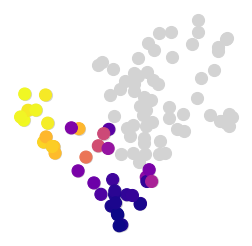

In [84]:
plt.figure(figsize=[3, 3])
plt.scatter(rna_meta_ad.obsm['X_umap'][:, 0], 
           rna_meta_ad.obsm['X_umap'][:, 1], s=75, color='lightgrey')
plt.scatter(rna_meta_ad[ct_meta_cells].obsm['X_umap'][:, 0], 
           rna_meta_ad[ct_meta_cells].obsm['X_umap'][:, 1], s=75, 
            c=rna_meta_pr_res.pseudotime[ct_meta_cells], 
           vmin=0, vmax=1, cmap=matplotlib.cm.plasma)


ax = plt.gca()
ax.set_axis_off()
plt.savefig(plot_prefix + f'ery_metacells_pseudotime.png', dpi=150)

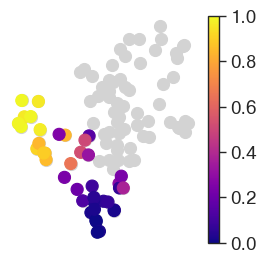

In [85]:
plt.figure(figsize=[3, 3])
plt.scatter(rna_meta_ad.obsm['X_umap'][:, 0], 
           rna_meta_ad.obsm['X_umap'][:, 1], s=75, color='lightgrey')
plt.scatter(rna_meta_ad[ct_meta_cells].obsm['X_umap'][:, 0], 
           rna_meta_ad[ct_meta_cells].obsm['X_umap'][:, 1], s=75, 
            c=rna_meta_pr_res.pseudotime[ct_meta_cells], 
           vmin=0, vmax=1, cmap=matplotlib.cm.plasma)


ax = plt.gca()
ax.set_axis_off()
plt.colorbar()
plt.savefig(plot_prefix + f'ery_metacells_pseudotime_colorbar.png', dpi=150)

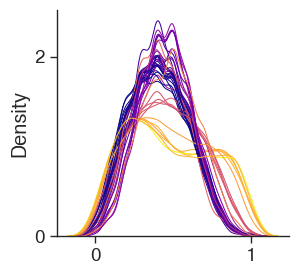

In [86]:
import matplotlib.colors as mcolors
colormap = matplotlib.cm.plasma
colorparams = rna_ad.obs['palantir_pseudotime'][ct_meta_cells].values
normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))

plt.figure(figsize=[3, 3])
for c in ct_meta_cells:
    sns.kdeplot(meta_dorc_peaks[c], legend=None, 
                color=colormap(normalize(rna_ad.obs['palantir_pseudotime'][c])), 
               linewidth=0.75)
sns.despine()
plt.xticks([0.0, 1.0])
plt.yticks([0.0, 2.0])
plt.xlabel('')
plt.savefig(plot_prefix + f'ery_metacells_pseudotime_tracks.png', dpi=150)

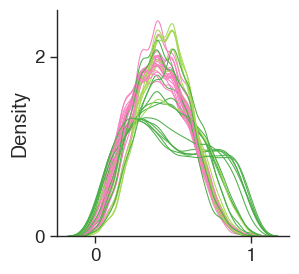

In [87]:
plt.figure(figsize=[3, 3])

for c in ct_meta_cells:
    sns.kdeplot(meta_dorc_peaks[c], legend=None, 
                color=ct_colors[rna_ad.obs['celltype'][c]], 
               linewidth=0.75)

sns.despine()
plt.xticks([0.0, 1.0])
plt.yticks([0.0, 2.0])
plt.xlabel('')
plt.savefig(plot_prefix + f'ery_metacells_tracks.png', dpi=150)

## Single cell results 

In [79]:
ct_sc_cells = sc_dorc_peaks.columns[rna_ad.obs['celltype'][sc_dorc_peaks.columns].isin(['HSC', 'MEP', 'Ery'])]

In [80]:
rna_meta_ad.obsm['X_umap'] = rna_ad[rna_meta_ad.obs_names, :].obsm['X_umap']

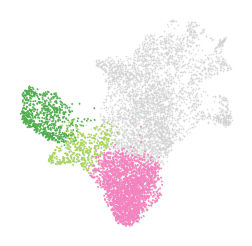

In [81]:
plt.figure(figsize=[3, 3])
plt.scatter(rna_ad.obsm['X_umap'][:, 0], 
           rna_ad.obsm['X_umap'][:, 1], s=0.1, color='lightgrey')
plt.scatter(rna_ad[ct_sc_cells].obsm['X_umap'][:, 0], 
           rna_ad[ct_sc_cells].obsm['X_umap'][:, 1], s=0.25, 
            color=ct_colors[rna_ad.obs['celltype'][ct_sc_cells]])


ax = plt.gca()
ax.set_axis_off()
plt.savefig(plot_prefix + f'umap_ery_lin.png', dpi=150)

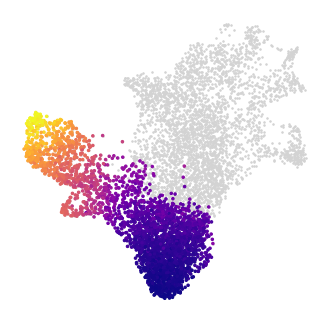

In [82]:
plt.scatter(rna_ad.obsm['X_umap'][:, 0], 
           rna_ad.obsm['X_umap'][:, 1], s=1, color='lightgrey')
plt.scatter(rna_ad[ct_sc_cells].obsm['X_umap'][:, 0], 
           rna_ad[ct_sc_cells].obsm['X_umap'][:, 1], s=3, 
            c=rna_ad.obs['palantir_pseudotime'][ct_sc_cells], 
           cmap=matplotlib.cm.plasma)


ax = plt.gca()
ax.set_axis_off()
plt.savefig(plot_prefix + f'ery_singlecells_pseudotime.png', dpi=150)

In [83]:
plot_cells = np.random.choice(ct_sc_cells, 100)

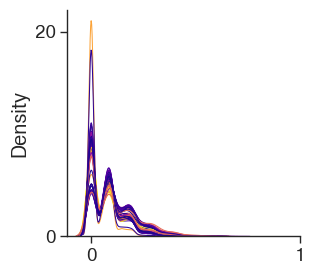

In [84]:
import matplotlib.colors as mcolors
colormap = matplotlib.cm.plasma
colorparams = rna_ad.obs['palantir_pseudotime'][plot_cells].values
normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))

plt.figure(figsize=[3, 3])
for c in plot_cells:
    sns.kdeplot(sc_dorc_peaks[c], legend=None, 
                color=colormap(normalize(rna_ad.obs['palantir_pseudotime'][c])), 
               linewidth=0.75)
sns.despine()
plt.xticks([0.0, 1.0])
plt.yticks([0.0, 20])
plt.xlabel('')
plt.savefig(plot_prefix + f'ery_singlecell_pseudotime_tracks.png', dpi=150)

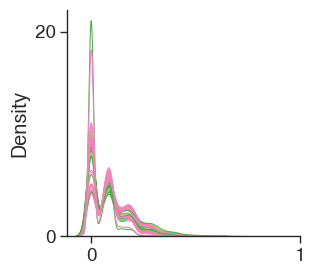

In [85]:
plt.figure(figsize=[3, 3])
for c in plot_cells:
    sns.kdeplot(sc_dorc_peaks[c], legend=None, 
                color=ct_colors[rna_ad.obs['celltype'][c]], 
               linewidth=0.75)
    
sns.despine()
plt.xticks([0.0, 1.0])
plt.yticks([0.0, 20])
plt.xlabel('')
plt.savefig(plot_prefix + f'ery_singlecell_tracks.png', dpi=150)

## Gene loci

In [86]:
cat_colors = pd.Series(sns.color_palette(n_colors=2).as_hex(), 
         index=['Low', 'High'])
gene_cats = pd.Series(dtype=object, index=lin_high_genes.union(lin_low_genes))
gene_cats[lin_high_genes] = 'High'
gene_cats[lin_low_genes] = 'Low'

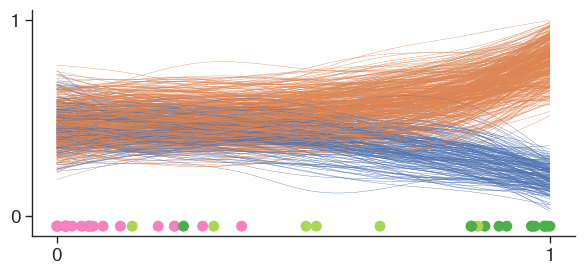

In [87]:
plt.figure(figsize=[7, 3])
for tf in gene_cats.index:
    plt.plot(ery_trend_df.columns, ery_trend_df.loc[tf,:], linewidth=0.25, 
            color=cat_colors[gene_cats[tf]])
plt.scatter(
    rna_meta_pr_res.pseudotime[ct_meta_cells],
    np.repeat(-0.05, len(ct_meta_cells)), 
    s=50, color=ct_colors[rna_ad.obs['celltype'][ct_meta_cells]]
)
sns.despine()
# plt.xlabel('Palantir pseudo-time')
# plt.ylabel('Fraction of open DORC peaks ')
plt.xticks([0.0, 1.0])
plt.yticks([0.0, 1.0])
plt.savefig(plot_prefix + f'lin_high_low_trends.png', dpi=150)

In [88]:
cat_colors

Low     #4c72b0
High    #dd8452
dtype: object

# Motifs

In [89]:
import logomaker

In [92]:
dorc_dir

'/home/ec2-user/projects/metacells/data/CD34/Multiome/outs/'

In [93]:
motifs = pd.read_table('/home/ec2-user/projects/metacells/data/CD34/Multiome/outs/dorc_associations/motifs.tsv', header=None)

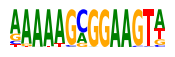

In [96]:
# NFIX
pwm = motifs.iloc[1:15, 1:].astype(float)
pwm.columns = ['A', 'C', 'G', 'T']
# seqlogo.seqlogo(seqlogo.Ppm(pwm.values), ic_scale = False, format = 'png', size = 'small')
plt.figure(figsize=[2, 0.5])
ax = plt.gca()
ax.set_axis_off()
crp_logo = logomaker.Logo(pwm, ax=ax)


plt.savefig(plot_prefix + f'motif_PU.1.png', dpi=150)

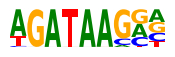

In [97]:
# NFIX
pwm = motifs.iloc[17:, 1:].astype(float)
pwm.columns = ['A', 'C', 'G', 'T']

# seqlogo.seqlogo(seqlogo.Ppm(pwm.values), ic_scale = False, format = 'png', size = 'small')
plt.figure(figsize=[2, 0.5])
ax = plt.gca()
ax.set_axis_off()
crp_logo = logomaker.Logo(pwm, ax=ax)

plt.savefig(plot_prefix + f'motif_GATA2.png', dpi=150)

# BMMC 

## Load data

In [8]:
import pickle

In [ ]:
with open(out_dir + 'bmmc_celltype_open_peaks.p', 'rb') as f:
    bmmc_ct_open_peaks, bmmc_ct_dorc_peaks = pickle.load(f)

with open(out_dir + 'bmmc_metacell_open_peaks.p', 'rb') as f:
    bmmc_mt_open_peaks, bmmc_mt_dorc_peaks = pickle.load(f)
    

In [11]:
bmmc_ad = sc.read('/home/ec2-user/projects/metacells/data/CD34/Granja_BMMC/bmmc_atac_notcells.h5ad')

In [12]:
bmmc_meta_ad = sc.read('/home/ec2-user/projects/metacells/data/CD34/Granja_BMMC/bmmc_meta_ad.h5ad')

In [13]:
bmmc_ad

AnnData object with n_obs × n_vars = 19438 × 249478
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'DoubletScore', 'DoubletEnrichment', 'Clusters', 'ReadsInPeaks', 'FRIP', 'Clusters_full', 'CellType', 'Metacell', 'Metacell_Entropy'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx'
    uns: 'CellType_colors', 'Clusters_colors', 'neighbors'
    obsm: 'X_svd', 'X_umap', 'X_umap_full'
    layers: 'TFIDF'
    obsp: 'connectivities', 'distances'

In [14]:
bmmc_meta_ad

AnnData object with n_obs × n_vars = 269 × 249478
    obs: 'celltype', 'palantir_pseudotime', 'CellType', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'CellType_colors', 'celltype_colors', 'hvg', 'neighbors', 'umap'
    obsm: 'X_svd', 'X_umap', 'X_umap_full'
    obsp: 'connectivities', 'distances'

In [163]:
bmmc_colors = pd.Series(bmmc_ad.uns['CellType_colors'], 
                       index=bmmc_ad.obs['CellType'].values.categories)
bmmc_colors[ct_colors.index.intersection(bmmc_colors.index)] = ct_colors[ct_colors.index.intersection(bmmc_colors.index)].values
bmmc_ad.uns['CellType_colors'] = bmmc_colors.values

In [19]:
45 * 0.65 / 12 * .88

2.145

## Celltypes

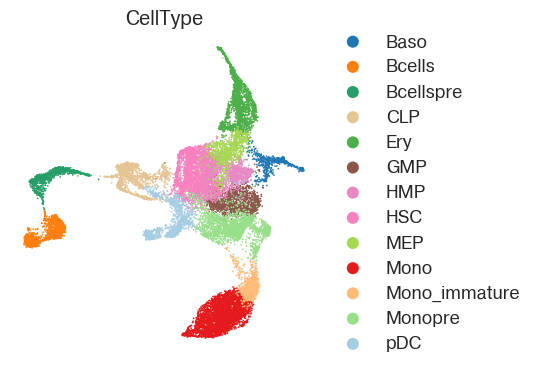

In [164]:
sc.pl.scatter(bmmc_ad, basis='umap', color='CellType', frameon=False)

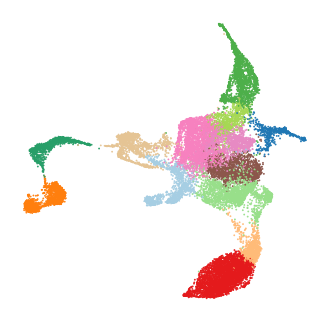

In [187]:
plt.figure(figsize=[4, 4])
umap = bmmc_ad.obsm['X_umap']
plt.scatter(umap[:, 0], umap[:, 1], s=0.25, 
           color=bmmc_colors[bmmc_ad.obs['CellType']])
ax = plt.gca()
ax.set_axis_off()
plt.savefig(plot_prefix + f'bmmc_celltypes.png', dpi=150)

In [188]:
pd.Series(bmmc_ad.uns['CellType_colors'], 
         index=bmmc_ad.obs['CellType'].values.categories)

Baso             #1f77b4
Bcells           #ff7f0e
Bcellspre        #279e68
CLP              #e5c494
Ery              #4daf4a
GMP              #8c564b
HMP              #e78ac3
HSC              #f781bf
MEP              #a6d854
Mono             #e41a1c
Mono_immature    #ffbb78
Monopre          #98df8a
pDC              #a6cee3
dtype: object

In [166]:
bmmc_ad

AnnData object with n_obs × n_vars = 19438 × 249478
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'DoubletScore', 'DoubletEnrichment', 'Clusters', 'ReadsInPeaks', 'FRIP', 'Clusters_full', 'CellType', 'Metacell', 'Metacell_Entropy'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx'
    uns: 'CellType_colors', 'Clusters_colors', 'neighbors'
    obsm: 'X_svd', 'X_umap', 'X_umap_full'
    layers: 'TFIDF'
    obsp: 'connectivities', 'distances'

In [ ]:
sample_colors=pd.Series(bmmc_ad.uns['Sample_colors'],
                        index=bmmc_ad.obs['Sample'].values.categories)

In [ ]:
plt.figure(figsize=[4, 4])
umap = bmmc_ad.obsm['X_umap']
rand_order = np.random.choice(np.arange(umap.shape[0]), 
                umap.shape[0], False)

plt.scatter(umap[rand_order, 0], umap[rand_order, 1], s=0.25, 
           color=sample_colors[bmmc_ad.obs['Sample']].values[rand_order])
ax = plt.gca()
ax.set_axis_off()
plt.savefig(plot_prefix + f'bmmc_samples.png', dpi=150)

No handles with labels found to put in legend.


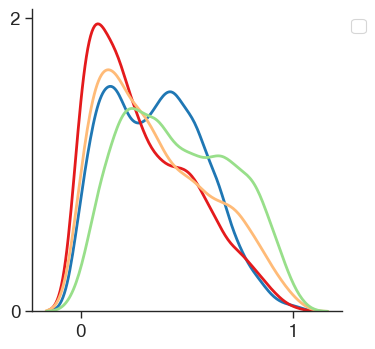

In [183]:
plt.figure()
for ct in [ 'Baso', 'Mono', 'Mono_immature', 'Monopre']:
    sns.kdeplot(bmmc_ct_dorc_peaks[ct], color=bmmc_colors[ct], linewidth=2)
sns.despine()
plt.legend(loc=2, bbox_to_anchor=(1, 1))

plt.xlabel('')
plt.ylabel('')
plt.yticks([0, 2])
plt.xticks([0, 1])
plt.savefig(plot_prefix + f'bmmc_mono_fractions.png', dpi=150)

No handles with labels found to put in legend.


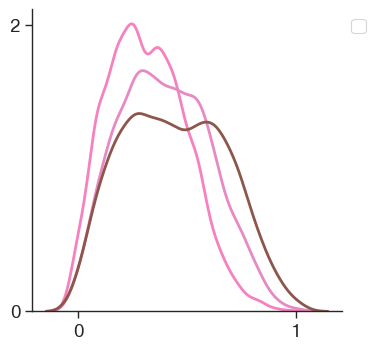

In [184]:
plt.figure()
for ct in ['HSC', 'HMP', 'GMP']:
    sns.kdeplot(bmmc_ct_dorc_peaks[ct], color=bmmc_colors[ct], linewidth=2)
sns.despine()
plt.legend(loc=2, bbox_to_anchor=(1, 1))

plt.xlabel('')
plt.ylabel('')
plt.yticks([0, 2])
plt.xticks([0, 1])

plt.savefig(plot_prefix + f'bmmc_stem_cell_fractions.png', dpi=150)

No handles with labels found to put in legend.


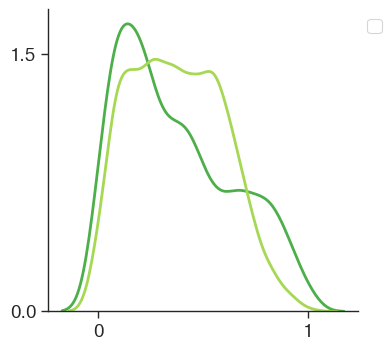

In [185]:
plt.figure()
for ct in ['Ery', 'MEP']:
    sns.kdeplot(bmmc_ct_dorc_peaks[ct], color=bmmc_colors[ct], linewidth=2)
sns.despine()
plt.legend(loc=2, bbox_to_anchor=(1, 1))

plt.xlabel('')
plt.ylabel('')
plt.yticks([0, 1.5])
plt.xticks([0, 1])

plt.savefig(plot_prefix + f'bmmc_ery_fractions.png', dpi=150)

No handles with labels found to put in legend.


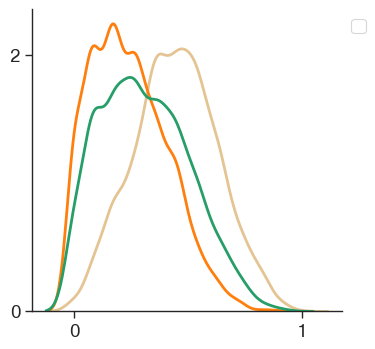

In [186]:
plt.figure()
for ct in ['CLP', 'Bcells', 'Bcellspre']:
    sns.kdeplot(bmmc_ct_dorc_peaks[ct], color=bmmc_colors[ct], linewidth=2)
sns.despine()
plt.legend(loc=2, bbox_to_anchor=(1, 1))

plt.xlabel('')
plt.ylabel('')
plt.yticks([0, 2])
plt.xticks([0, 1])

plt.savefig(plot_prefix + f'bmmc_bcell_fractions.png', dpi=150)

## Monocyte dynamics

In [52]:
plot_ct = ['HSC','HMP',  'GMP', 'Monopre', 'Mono_immature', 'Mono']#, 'HMP', 'Mono']
ct_meta_cells = bmmc_mt_dorc_peaks.columns[bmmc_ad.obs['CellType'][bmmc_mt_dorc_peaks.columns].isin(plot_ct)]

In [53]:
bmmc_meta_ad
plt

AnnData object with n_obs × n_vars = 269 × 249478
    obs: 'celltype', 'palantir_pseudotime', 'CellType', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'CellType_colors', 'celltype_colors', 'hvg', 'neighbors', 'umap'
    obsm: 'X_svd', 'X_umap', 'X_umap_full'
    obsp: 'connectivities', 'distances'

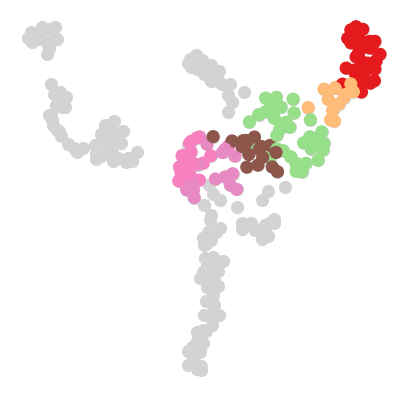

In [56]:
plt.figure(figsize=[5, 5])
plt.scatter(bmmc_meta_ad.obsm['X_umap'][:, 0], 
           bmmc_meta_ad.obsm['X_umap'][:, 1], s=75, color='lightgrey')
plt.scatter(bmmc_meta_ad[ct_meta_cells].obsm['X_umap'][:, 0], 
           bmmc_meta_ad[ct_meta_cells].obsm['X_umap'][:, 1], s=75, 
            color=bmmc_colors[bmmc_ad.obs['CellType'][ct_meta_cells]])


ax = plt.gca()
ax.set_axis_off()
plt.savefig(plot_prefix + f'bmmc_metacells.png', dpi=150)

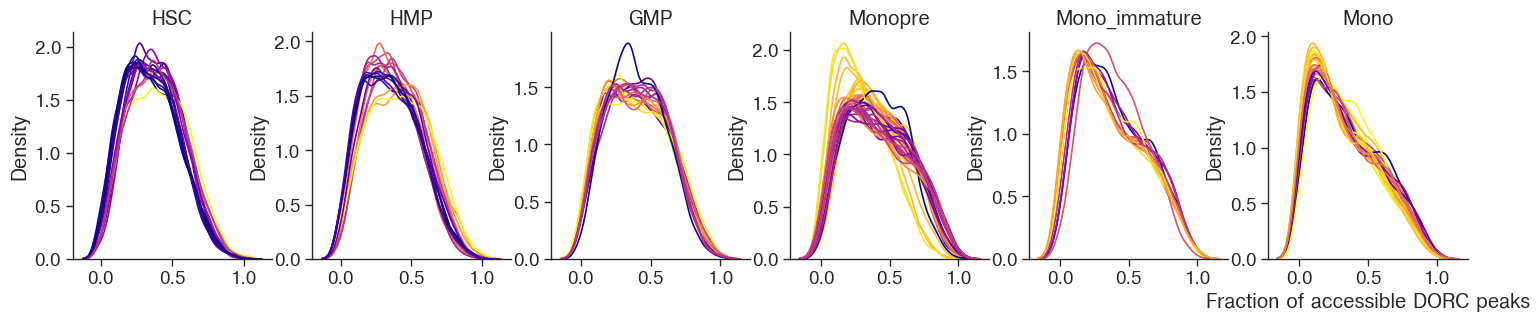

In [112]:
colormap = matplotlib.cm.plasma
plot_ct = ['HSC','HMP',  'GMP', 'Monopre', 'Mono_immature', 'Mono']#, 'HMP', 'Mono']
fig = palantir.plot.FigureGrid(len(plot_ct), len(plot_ct))

for ct, ax in zip(plot_ct, fig):
    ct_meta_cells = bmmc_mt_dorc_peaks.columns[bmmc_ad.obs['CellType'][bmmc_mt_dorc_peaks.columns] == ct]
    colorparams = bmmc_meta_ad.obs['palantir_pseudotime'][ct_meta_cells].values
    normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))

    for c in ct_meta_cells:
        sns.kdeplot(bmmc_mt_dorc_peaks[c], legend=None, 
                    color=colormap(normalize(bmmc_meta_ad.obs['palantir_pseudotime'][c])), 
                   ax=ax)
    ax.set_title(ct)
    ax.set_xlabel("")
sns.despine()
ax.set_xlabel('Fraction of accessible DORC peaks')
plt.savefig(plot_prefix + f'bmmc_mono_trends_sep_pt.png', dpi=150)

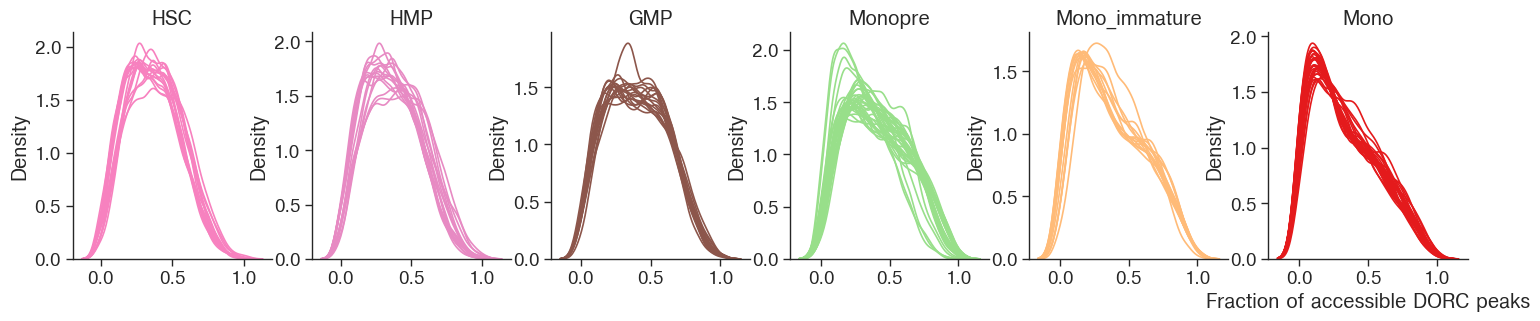

In [113]:
colormap = matplotlib.cm.plasma
plot_ct = ['HSC','HMP',  'GMP', 'Monopre', 'Mono_immature', 'Mono']#, 'HMP', 'Mono']
fig = palantir.plot.FigureGrid(len(plot_ct), len(plot_ct))

for ct, ax in zip(plot_ct, fig):
    ct_meta_cells = bmmc_mt_dorc_peaks.columns[bmmc_ad.obs['CellType'][bmmc_mt_dorc_peaks.columns] == ct]
    colorparams = bmmc_meta_ad.obs['palantir_pseudotime'][ct_meta_cells].values
    normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))

    for c in ct_meta_cells:
        sns.kdeplot(bmmc_mt_dorc_peaks[c], legend=None, 
                    color=bmmc_colors[bmmc_ad.obs['CellType'][c]],
                   ax=ax)
    ax.set_title(ct)
    ax.set_xlabel("")
sns.despine()
ax.set_xlabel('Fraction of accessible DORC peaks')
plt.savefig(plot_prefix + f'bmmc_mono_trends_sep_ct.png', dpi=150)